   # EDA for CelebA dataset

For first stage of experiments, we will require facial landmark detection as well as facial attribute estimation. For facial landmark detection, we will use dlib as a benchmark landmark detector. The dataset we will be using is the CelebA dataset. The CelebA dataset includes 200k celebrity images each with 40 attribute annotations (binary). The images in the dataset cover large pose variations and background clutter. CelebA has:
* 10,177 number of identities,
* 202,599 number of face images, and 
* 5 landmark locations, 40 binary attributes annotations per image

## Load Images from CelebA

In [1]:
import os 
import pandas as pd
import numpy as np
import cv2
import PIL

from PIL import Image
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt 

In [2]:
# try loading a sample image
image_path = '.\data\img_align_celeba.zip'
target_path = '.\data\sample_imgs'

def load_images(target_path=target_path,image_path=image_path,N=20):
    """
    unpacks celebA image up till Nth image,
    returns file path where images are stored"""
    with zipfile.ZipFile(image_path, 'r') as zip_obj:
        fileNameLs = zip_obj.namelist()
        for filename in fileNameLs[1:N+1]: # skip first dir
            zip_obj.extract(filename, target_path)
        print(f"files stored in {target_path}\\{fileNameLs[0][:-1]}")

In [29]:
load_images()

files stored in .\data\sample_imgs\img_align_celeba


Lets view a sample of this images

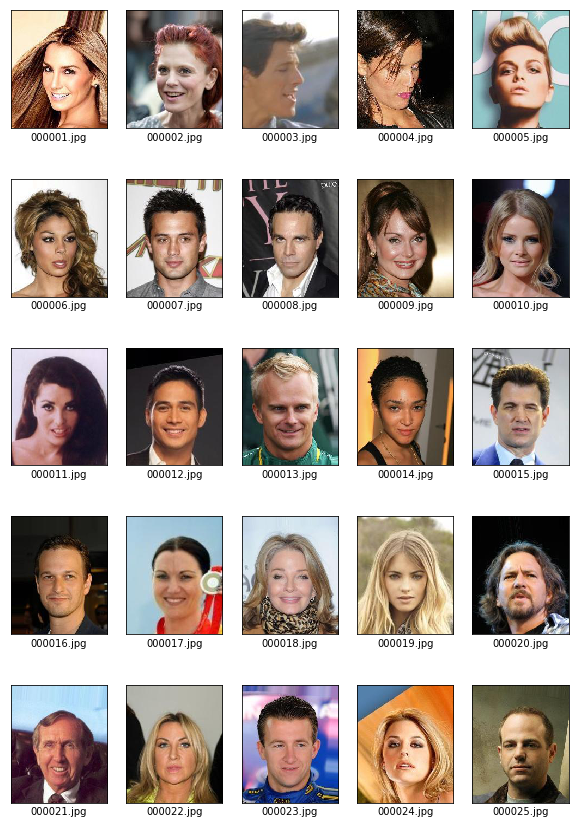

In [272]:
sample_img_dir = '.\data\sample_imgs\img_align_celeba'
plt.figure(figsize=(10,15))
image_name_ls = os.listdir(sample_img_dir)
for i in range(len(image_name_ls[:25])):
    img_path = sample_img_dir+'\\'+ image_name_ls[i] 
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5,5,i+1)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(image_name_ls[i])
    plt.imshow(image_rgb)
plt.show()


## Try using face detection and landmark detection pre-trained from dlib

In [4]:
import dlib
import imutils
from imutils import face_utils

In [5]:
# init detector 
shape_pred_dir = './landmark-detector/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_pred_dir)

*code adapted from [here]( https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/)*


In [6]:
# try to detect face on sample images
# code adapted from https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/
sample_img_dir = '.\data\sample_imgs\img_align_celeba'
plt.figure(figsize=(10,15))
image_name_ls = os.listdir(sample_img_dir)
for i in range(len(image_name_ls[:25])):
    img_path = sample_img_dir+'\\'+ image_name_ls[i] 
    image = cv2.imread(img_path)
    image = imutils.resize(image, width=500)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(image_gray, 1) # number of image pyramid layers to apply when upscaling the image prior to applying the detector
    for (j, rect) in enumerate(rects):
        shape = predictor(image_gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        (x, y , w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2) # this is the bbox
        
        for (x, y) in shape:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1) # this is the landmarks
    cv2.imshow("Output", image) 
    cv2.waitKey(0) # press any key to cycle the images
cv2.destroyAllWindows()


<Figure size 720x1080 with 0 Axes>

### Using facial landmarks to mask faces 

In [86]:
# try to detect face on sample images, mask faces
# code adapted from https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/
sample_img_dir = '.\data\sample_imgs\img_align_celeba'
plt.figure(figsize=(10,15))
image_name_ls = os.listdir(sample_img_dir)
for i in range(len(image_name_ls[:25])):
    img_path = sample_img_dir+'\\'+ image_name_ls[i] 
    image = cv2.imread(img_path)
    image = imutils.resize(image, width=500)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(image_gray, 1) # number of image pyramid layers to apply when upscaling the image prior to applying the detector
    for (j, rect) in enumerate(rects):
        shape = predictor(image_gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        (x, y , w, h) = face_utils.rect_to_bb(rect)
        # use thickness = -1 to fill rectangle
        thickness = -1
#         cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 0), thickness) # this is the bbox
        center = shape[28] # center is point 34
        axesLengthwidth = shape[11][0]-shape[6][0] #this is the width point 2 minus point 16  
        axesLengthheight = abs(shape[27][1]-shape[6][1])
        axesLength = (axesLengthwidth, axesLengthheight)
        cv2.ellipse(image, (center[0],center[1]),axesLength,angle=0,
                    startAngle=0,endAngle=360,color=(0,0,0),thickness=thickness)
    cv2.imshow("Output", image) 
    cv2.waitKey(0) # press any key to cycle the images
cv2.destroyAllWindows()


<Figure size 720x1080 with 0 Axes>

### Simple EDA for attributes

In [274]:
# plot of the distribution of attributes in the CelebA dataset
# load the facial attributes into a pandas dataframe, only the first 10000 images
file_path = './data/list_attr_celeba.txt'
attributes_full = []
header = ['image_id']
with open(file_path, 'r') as attribs:
    for i,line in enumerate(attribs):
        if i == 0:
            continue # first row indicates total number of pictures
        if i == 1:
            header+=line.split()
        else:
            attributes_full.append([0 if x == '-1' else 1 
                         for x in line.split()]) # change to 1-hot             


In [275]:
full_attributes_df = pd.DataFrame(attributes_full, columns=header)

In [278]:
print(full_attributes_df.shape)

(202599, 41)


In [276]:
full_attributes_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,1,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [286]:
count_plt_s = full_attributes_df.sum()/full_attributes_df.count()

In [290]:
count_plt_s = count_plt_s.drop('image_id')

In [292]:
import seaborn as sns
sns.set_style(style='darkgrid')

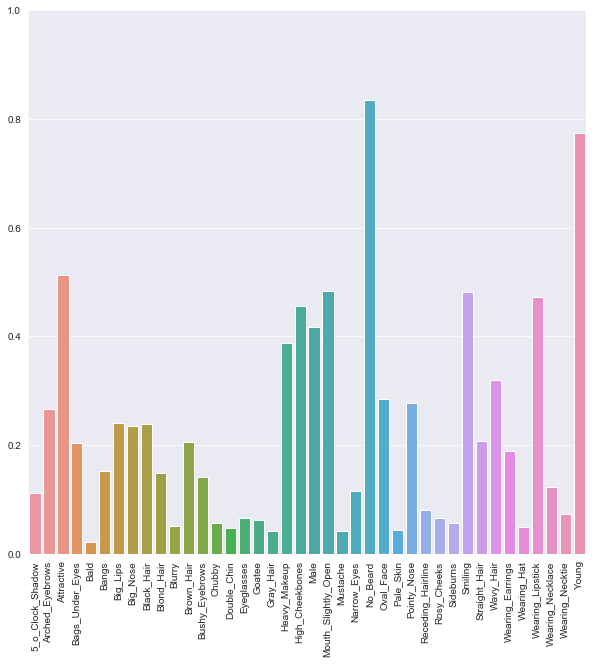

In [305]:
plt.figure(figsize=(10,10))
sns.barplot(x = count_plt_s.index, y = count_plt_s)
plt.xticks(rotation=90)
plt.ylim((0,1))
plt.show()

Majority of classes are imbalanced 